In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from termcolor import colored

face_cascade = cv2.CascadeClassifier('/home/mckc/Downloads/opencv-2.4.13/data/haarcascades_GPU/haarcascade_frontalface_default.xml')

In [2]:
#Reading the image data into numpy
def rgb2gray(rgb):
    return np.dot(rgb[:,:,:], [0.299, 0.587, 0.114])

def load_data():
    import pandas as pd
    import numpy as np
    from PIL import Image
    
    train = pd.read_csv('/home/mckc/Images/train.csv')
    test = pd.read_csv('/home/mckc/Images/test.csv')
    print 'the training data shape is ',train.shape
    print 'the test data shape is ', test.shape
    
    X_tr = np.zeros((1,1944,2592),dtype=np.uint8)
    for i in train.values[:,0]:
        image = rgb2gray(np.array(Image.open(i))).astype(np.uint8).reshape(1,1944,2592)
#     print X_tr.shape,image.shape
        X_tr =  np.vstack((X_tr,image))
    Y_tr = train.values[:,1]
    X_tr = X_tr[1:,:,:]
    X_ts = np.zeros((1,1944,2592),dtype=np.uint8)
    for i in test.values[:,0]:
        image = rgb2gray(np.array(Image.open(i))).astype(np.uint8).reshape(1,1944,2592)
        X_ts = np.vstack((X_ts,image))
    Y_ts = test.values[:,1]
    X_ts = X_ts[1:,:,:]
    print 'the training file shape',X_tr.shape,Y_tr.shape
    print 'the testing file shape',X_ts.shape,Y_ts.shape
    
    return X_tr,X_ts,Y_tr,Y_ts    

In [3]:
def simulate(X,Y):
    import scipy as sp
    from scipy import misc
    complete = np.zeros((1,1944,2592),dtype=np.uint8)
    Y_complete = []
    for i in range(len(X)):
        complete = np.vstack((complete,X[i,:,:].reshape(1,1944,2592)))
        complete = np.vstack((complete,sp.misc.imrotate(X[i,:,:], angle = 5).reshape(1,1944,2592)))
        complete = np.vstack((complete,sp.misc.imrotate(X[i,:,:], angle = 10).reshape(1,1944,2592)))
        complete = np.vstack((complete,sp.misc.imrotate(X[i,:,:], angle = 15).reshape(1,1944,2592)))
        complete = np.vstack((complete,sp.misc.imrotate(X[i,:,:], angle = -5).reshape(1,1944,2592)))
        complete = np.vstack((complete,sp.misc.imrotate(X[i,:,:], angle = -15).reshape(1,1944,2592)))
        complete = np.vstack((complete,sp.misc.imrotate(X[i,:,:], angle = -10).reshape(1,1944,2592)))
        rotated = np.fliplr(X[i,:,:])
        complete = np.vstack((complete,sp.misc.imrotate(rotated, angle = 5).reshape(1,1944,2592)))
        complete = np.vstack((complete,sp.misc.imrotate(rotated, angle = 10).reshape(1,1944,2592)))
        complete = np.vstack((complete,sp.misc.imrotate(rotated, angle = 15).reshape(1,1944,2592)))
        complete = np.vstack((complete,sp.misc.imrotate(rotated, angle = -5).reshape(1,1944,2592)))
        complete = np.vstack((complete,sp.misc.imrotate(rotated, angle = -10).reshape(1,1944,2592)))
        complete = np.vstack((complete,sp.misc.imrotate(rotated, angle = -15).reshape(1,1944,2592)))
        complete = np.vstack((complete,rotated.reshape(1,1944,2592)))
        Y_complete = np.append(Y_complete,([Y[i]]*14))
        if i % 10==0:
            print colored((float(i)/len(X)*100 ,' Percentage complete'),'green')
    complete = complete[1:,:,:]
    return complete,Y_complete

In [4]:
def extract_faces(X_tr,Y_tr):
    from skimage.transform import resize
    import time
    start_time = time.clock()
    all_faces = np.zeros((1,96,96),dtype=np.uint8)
    missing = []
    multiple = []
    Y= []
    for i in range(len(X_tr)):
        faces  = face_cascade.detectMultiScale(X_tr[i,:,:],scaleFactor=1.3,minNeighbors=5,minSize=(70, 70))
        n_faces = len(faces)
        if n_faces is 1:
            for (x,y,w,h) in faces:
                fac = np.array(X_tr[i,:,:])[y:(y+h),x:(x+h)]
                out = (resize(fac,(96,96))).reshape((1,96,96))
                all_faces = np.vstack((all_faces,out))
                Y = np.append(Y,Y_tr[i])
        else:
            if n_faces > 1:
                #print ('There are multiple faces for index %d and with length %d' % (i , n_faces))
                missing = np.append(missing,i)
                #all_faces = np.vstack((all_faces,np.zeros((1,96,96),dtype=np.uint8)))
            else:
                #print ('The face is missing for index %d' %i)
                multiple = np.append(multiple,i)
        if i % 50==0:
            print colored((float(i)/len(X_tr)*100 ,' Percentage complete'), 'green')

    all_faces = all_faces[1:,:,:]
    print all_faces.shape
    print time.clock() - start_time, "seconds"
    return all_faces,missing,multiple,Y

In [5]:
X_tr,X_tst,Y_tr,Y_tst = load_data()

IOError: File /home/mckc/Images/train.csv does not exist

In [6]:
import time
start_time = time.clock()
X_train,Y_train = simulate(X_tr,Y_tr)
print X_train.shape,Y_train.shape
print time.clock() - start_time, "seconds"

(0.0, ' Percentage complete')


KeyboardInterrupt: 

In [7]:
X,missing,multiple,Y = extract_faces(X_train[:,:,:],Y_train)
X_test,missing_test,multiple_test,Y_test = extract_faces(X_tst,Y_tst)

NameError: name 'X_train' is not defined

In [18]:
def Save_data(X,Y):
    for i in range(len(X)):
        file_name = '/home/mckc/imagees/'+Y[i]+'_'+str(i)+'.npy'
        np.save(file_name,X[i,:,:])

In [21]:
def load():
    import os
    import numpy as np
    files = os.listdir('/home/mckc/imagees/')
    X = []
    Y = []
    for i in files:
        X = np.append(X,np.load(i))
        index = i.index('_')
        Y = np.append(Y,i[:index])
    return X,Y

(1706, 96, 96)

In [ ]:
from PIL import Image
image = np.array(Image.open(train.values[3,0]))
plt.imshow(X_tr[1,:,:], cmap = cm.Greys_r)
plt.show()

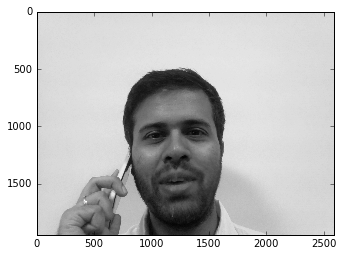

In [83]:
# get row number
def rgb2gray(rgb):
    return np.dot(rgb[:,:,:], [0.299, 0.587, 0.114])

gray = rgb2gray(image).astype(np.uint8)
gray.shape
plt.imshow(gray, cmap = plt.get_cmap('gray'))
plt.show()

Found 1 faces!


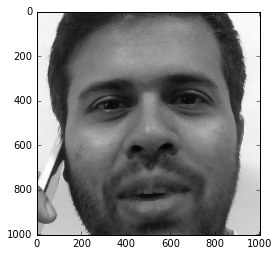

In [45]:
faces = face_cascade.detectMultiScale(
    gray,
    scaleFactor=1.3,
    minNeighbors=6,
    minSize=(40, 40))
print "Found {0} faces!".format(len(faces))
for (x,y,w,h) in faces:
    fac = np.array(gray)[y:(y+h),x:(x+h)]
    
plt.imshow(fac,cmap=plt.get_cmap('gray'))


In [7]:
#Normalising
X = X -0.5
X_test = X_test - 0.5

print X.mean(),X_test.mean()

In [3]:
X.mean()

0.036512346746588729

In [13]:
map, Y_number = np.unique(Y, return_inverse=True)
Y_test_numer = np.unique(Y_test, return_inverse=True)[1]

In [14]:
print map,X.dtype

['Abhay' 'Gopika'] float64


In [15]:
print len(X),len(Y_number),X.shape

15722496 1706 (15722496,)


In [16]:
X = X.astype(np.float16)
X_test = X_test.astype(np.float16)

In [165]:
import lasagne
#from lasagne.layers.cuda_convnet import Conv2DCCLayer as Conv2DLayer
#from lasagne.layers.cuda_convnet import MaxPool2DCCLayer as MaxPool2DLayer
from lasagne import layers
from lasagne.objectives import categorical_crossentropy
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import BatchIterator,visualize,NeuralNet
Conv2DLayer = layers.Conv2DLayer
MaxPool2DLayer = layers.MaxPool2DLayer

net = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', Conv2DLayer),
        ('pool1', MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),
        ('conv2', Conv2DLayer),
        ('pool2', MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),
        ('conv3', Conv2DLayer),
        ('pool3', MaxPool2DLayer),
        ('dropout3', layers.DropoutLayer),
        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    dropout1_p=0.1,
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    dropout2_p=0.2,
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    dropout3_p=0.3,
    hidden4_num_units=1000,
    dropout4_p=0.5,
    hidden5_num_units=1000,
    output_nonlinearity=lasagne.nonlinearities.softmax,
    output_num_units=2,
    
    update = nesterov_momentum,
    update_learning_rate=0.001,
    update_momentum=0.9,
    max_epochs=500,
    verbose=1,
)
net.fit(X.reshape(-1,1,96,96), Y_number.astype(np.uint8))

# Neural Network with 16533474 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x46x46
  5  pool2     64x23x23
  6  dropout2  64x23x23
  7  conv3     128x22x22
  8  pool3     128x11x11
  9  dropout3  128x11x11
 10  hidden4   1000
 11  dropout4  1000
 12  hidden5   1000
 13  output    2

  epoch    trn loss    val loss    trn/val    valid acc  dur
-------  ----------  ----------  ---------  -----------  ------
      1     0.69386     0.69041    1.00499      0.67251  46.65s
      2     0.68817     0.68435    1.00558      0.75731  44.38s
      3     0.68142     0.67762    1.00561      0.58480  44.78s
      4     0.67365     0.67043    1.00480      0.56725  46.58s
      5     0.66619     0.66254    1.00550      0.59064  43.95s
      6     0.65711     0.65319    1.00601      0.69006  42.65s
      7     0.64663     0.64165    1.00777      0.7

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7ff4bcec2710>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7ff4bcec2610>,
     check_input=True, conv1_filter_size=(3, 3), conv1_num_filters=32,
     conv2_filter_size=(2, 2), conv2_num_filters=64,
     conv3_filter_size=(2, 2), conv3_num_filters=128, custom_scores=None,
     dropout1_p=0.1, dropout2_p=0.2, dropout3_p=0.3, dropout4_p=0.5,
     hidden4_num_units=1000, hidden5_num_units=1000,
     input_shape=(None, 1, 96, 96),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv1', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool1', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('dropout1', <class 'lasagne.layers.noise.DropoutLayer'>), ('conv2', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool2', <cla..., <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=

In [18]:
predicted = net.predict((X_test.reshape(-1,1,96,96)))

In [19]:
def names(x): return map(x)

In [ ]:
predicted_names = []
for i in predicted:
    predicted_names = np.append(predicted_names,map[i])
    
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, predicted_names)

In [22]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, predicted_names)

array([[19,  0],
       [ 0, 25]])

In [ ]:
%%capture
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import backend as K
from keras.optimizers import Adam,SGD
from keras.utils import np_utils


Y_Keras = np_utils.to_categorical(Y_number, 2)
# Create first network with Keras
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
model = Sequential()
model.add(Dense(1000, input_dim=9216,activation='relu'))
model.add(Dense(2,activation='softmax'))
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

import time
model.fit(X.reshape(-1,9216), Y_Keras, nb_epoch=100, batch_size=5,verbose=1,
         validation_data=(X_test.reshape(-1,9216), np_utils.to_categorical(Y_test_numer, 2)))
time.sleep(1)

In [28]:
X_normal = X.reshape(-1,9216)
X_test_normal = X_test.reshape(-1,9216)

In [100]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(verbose=1,n_jobs=-1)
clf.fit(X_normal,Y_number)
Y_logictic= clf.predict(X_test.reshape(-1,9216))

[LibLinear]

In [101]:
from sklearn.cross_validation import cross_val_score
score = cross_val_score(clf,X_normal,Y_number)

[LibLinear][LibLinear][LibLinear]

In [102]:
score

array([ 0.99648506,  0.99824253,  1.        ])

In [90]:
predicted_names = []
for i in Y_logictic:
    predicted_names = np.append(predicted_names,map[i])
    
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, predicted_names)

array([[19,  0],
       [ 0, 25]])

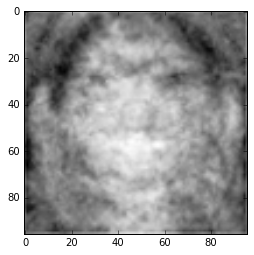

In [92]:
plt.imshow(clf.coef_.reshape(96,96),cmap=cm.Greys_r)

In [93]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
scores = list()
scores_std = list()
n_trees = [10,   50,  150,250,500]

In [94]:
for n_tree in n_trees:
        print(n_tree)
        recognizer = RandomForestClassifier(n_tree,verbose=0,oob_score=True,n_jobs=5)
        score = cross_val_score(recognizer, X_normal, Y_number)
        scores.append(np.mean(score))
        scores_std.append(np.std(score))

10
50
150
250
500


('Score: ', array([ 0.99706985,  0.99824253,  0.99824253,  0.99824253,  0.99824253]))
('Std  : ', array([ 0.00165623,  0.00143497,  0.00143497,  0.00143497,  0.00143497]))


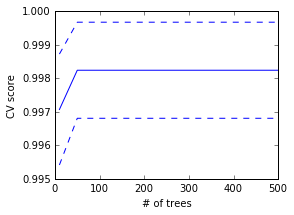

In [95]:
sc_array = np.array(scores)
std_array = np.array(scores_std)
print('Score: ', sc_array)
print('Std  : ', std_array)

plt.figure(figsize=(4,3))
plt.plot(n_trees, scores)
plt.plot(n_trees, sc_array + std_array, 'b--')
plt.plot(n_trees, sc_array - std_array, 'b--')
plt.ylabel('CV score')
plt.xlabel('# of trees')
#plt.savefig('cv_trees.png')
plt.show()

In [96]:
recognizer = RandomForestClassifier(n_tree,verbose=1,oob_score=True,n_jobs=5)
recognizer.fit(X_normal,Y_number)


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:    4.3s
[Parallel(n_jobs=5)]: Done 500 out of 500 | elapsed:    4.8s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=5,
            oob_score=True, random_state=None, verbose=1, warm_start=False)

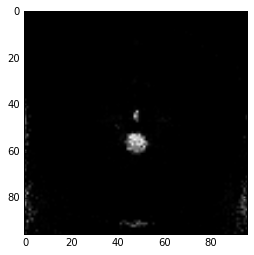

In [97]:
importances = recognizer.feature_importances_
importance_image = importances.reshape(96,96)
#plt.figure(figsize=(7,7))
plt.imshow(importance_image,cmap=cm.Greys_r)

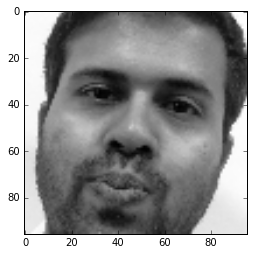

In [98]:
plt.imshow(X_normal[1,:].reshape(96,96),cmap=cm.Greys_r)

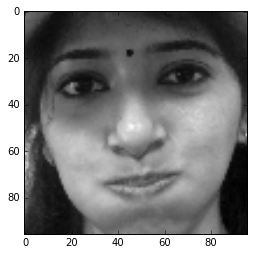

In [99]:
plt.imshow(X_normal[700,:].reshape(96,96),cm.Greys_r)

[[70 37 59 59]]
Linear Regression result ['Gopika']
Random Forest Value ['Gopika']


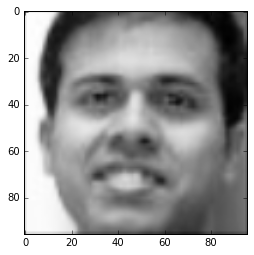

In [157]:
jpgfile = Image.open("/home/mckc/Downloads/1.jpg")
grey = rgb2gray(np.array(jpgfile))
faces  = face_cascade.detectMultiScale(grey.astype(np.uint8),scaleFactor=1.1,minNeighbors=3,minSize=(30, 30))
print faces


for (x,y,w,h) in faces:
    fac = np.array(grey[y:(y+h),x:(x+h)])
    out = resize(fac,(96,96))
    
plt.imshow(out,cmap=cm.Greys_r)

from sklearn.ensemble import RandomForestClassifier
recognizer = RandomForestClassifier(500,verbose=0,oob_score=True,n_jobs=5)
recognizer.fit(X_normal,Y_number)

trial = out.astype(np.float64)
print 'Linear Regression Value',map[clf.predict(trial.reshape(-1,9216))]
print 'Random Forest Value',map[recognizer.predict(trial.reshape(-1,9216))]
print 'Lasagne Value',map[recognizer.predict(trial.reshape(-1,1,96,96))]
print 'Keras Value',map[recognizer.predict(trial.reshape(-1,1,96,96))]

In [ ]:
jpgfile = Image.open("/home/mckc/Downloads/2.jpg")
grey = rgb2gray(np.array(jpgfile))
faces  = face_cascade.detectMultiScale(grey.astype(np.uint8),scaleFactor=1.1,minNeighbors=3,minSize=(30, 30))
print faces


for (x,y,w,h) in faces:
    fac = np.array(grey[y:(y+h),x:(x+h)])
    out = resize(fac,(96,96))
    
plt.imshow(out,cmap=cm.Greys_r)

from sklearn.ensemble import RandomForestClassifier
recognizer = RandomForestClassifier(500,verbose=0,oob_score=True,n_jobs=5)
recognizer.fit(X_normal,Y_number)

trial = out.astype(np.float64)
print 'Linear Regression Value',map[clf.predict(trial.reshape(-1,9216))]
print 'Random Forest Value',map[recognizer.predict(trial.reshape(-1,9216))]
print 'Lasagne Value',map[recognizer.predict(trial.reshape(-1,1,96,96))]
print 'Keras Value',map[recognizer.predict(trial.reshape(-1,1,96,96))]